<a href="https://colab.research.google.com/github/ayseakbaba/RESNET_WITH_ROBOFLOW/blob/main/RESNET_WITH_ROBOFLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [102]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from PIL import Image
import glob
from roboflow import Roboflow
from torchvision.datasets import ImageFolder

In [87]:
# Roboflow API anahtarını ayarla ve veri kümesini indir
rf = Roboflow(api_key="lsVeO6lWYyv9nNkhjYkI")
project = rf.workspace("turkish-sign-language-tsl").project("signbridge")
version = project.version(27)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


#Roboflowdan alınan resimlerin labellara göre atanması

In [90]:
%cd /content/SignBridge-27/

/content/SignBridge-27


In [99]:
import os
import shutil
import glob
from pathlib import Path

# Define the mapping from class IDs to characters
class_to_char = {
    0: 'A', 1: '6', 2: 'B', 3: '5', 4: '1',
    5: ' ', 6: 'C', 7: 'D', 8: '9',
    9: '4', 10: 'E', 11: 'F', 12: 'G', 13: 'H',
    14: 'I', 15: '2', 16: 'J', 17: 'K',
    18: 'L', 19: 'M', 20: 'N', 21: 'O', 22: 'P',
    23: 'R', 24: 'S', 25: '8', 26: '0', 27: 'T', 28: 'U',
    29: '3', 30: 'V', 31: 'Y', 32: '7', 33: 'Z'
}

def find_matching_image(images_path, label_filename):
    """Find the matching image file regardless of extension"""
    # Get the base name without extension
    base_name = os.path.splitext(label_filename)[0]

    # Look for any image file with the same base name but different extensions
    potential_image_patterns = [
        os.path.join(images_path, f"{base_name}.*"),
        os.path.join(images_path, f"{base_name}")
    ]

    for pattern in potential_image_patterns:
        matching_files = glob.glob(pattern)
        for file in matching_files:
            # Check if it's an image file (can expand this list as needed)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                return file

    # If we can't find a direct match, try a more flexible approach
    # Remove the .txt extension from label file and look for any file that starts with that name
    label_prefix = os.path.splitext(label_filename)[0]
    all_images = glob.glob(os.path.join(images_path, '*'))
    for image_path in all_images:
        image_name = os.path.basename(image_path)
        if image_name.startswith(label_prefix.split('.')[0]):
            return image_path

    return None

def process_dataset(base_path, output_base_path):
    """
    Process both train and test datasets
    """
    # Print the directories to help debug
    print(f"Looking for folders in: {base_path}")
    if os.path.exists(base_path):
        print(f"Contents of {base_path}: {os.listdir(base_path)}")
    else:
        print(f"Base path {base_path} does not exist!")
        return

    for dataset_type in ['train', 'test']:
        dataset_path = os.path.join(base_path, dataset_type)

        # Verify the dataset directory exists
        if not os.path.exists(dataset_path):
            print(f"Warning: {dataset_path} directory not found")
            continue

        print(f"Processing {dataset_type} dataset...")
        print(f"Contents of {dataset_path}: {os.listdir(dataset_path)}")

        # Define paths - directly under train/test folder
        images_path = os.path.join(dataset_path, 'images')
        labels_path = os.path.join(dataset_path, 'labels')

        # Verify paths exist
        if not os.path.exists(images_path):
            print(f"Error: Images path {images_path} does not exist")
            continue

        if not os.path.exists(labels_path):
            print(f"Error: Labels path {labels_path} does not exist")
            continue

        # Create output directory for this dataset type
        dataset_output_path = os.path.join(output_base_path, dataset_type)
        os.makedirs(dataset_output_path, exist_ok=True)

        # Create a count to track successful copies
        successful_copies = 0
        failed_matches = 0

        # Process all label files
        for label_file in os.listdir(labels_path):
            if label_file.endswith('.txt'):
                # Try to find the matching image
                image_path = find_matching_image(images_path, label_file)

                # Check if we found a matching image
                if image_path is None:
                    print(f"Warning: No matching image found for label {label_file}")
                    failed_matches += 1
                    continue

                # Read the label file to get the class ID
                with open(os.path.join(labels_path, label_file), 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:  # Format: class_id x_center y_center width height
                            class_id = int(parts[0])

                            # Get the corresponding character
                            if class_id in class_to_char:
                                char = class_to_char[class_id]

                                # Create directory for this character if it doesn't exist
                                char_dir = os.path.join(dataset_output_path, char)
                                os.makedirs(char_dir, exist_ok=True)

                                # Copy the image to the appropriate character directory
                                image_name = os.path.basename(image_path)
                                dest_path = os.path.join(char_dir, image_name)
                                shutil.copy2(image_path, dest_path)
                                print(f"Copied {image_name} to {char} directory (class_id: {class_id})")
                                successful_copies += 1
                            else:
                                print(f"Warning: Unknown class ID {class_id} in {label_file}")

        print(f"Dataset {dataset_type} processing complete.")
        print(f"Successfully copied {successful_copies} images.")
        print(f"Failed to find matches for {failed_matches} label files.")

if __name__ == "__main__":
    # Ask for the base path - this is where train and test folders are located
    base_path = input("Enter the base path where your train and test folders are located: ")
    output_base_path = input("Enter the output path where you want the organized images: ")

    # If paths are empty, use defaults
    if not base_path:
        base_path = "dataset"
    if not output_base_path:
        output_base_path = "organized_dataset"

    # Create the output directory if it doesn't exist
    os.makedirs(output_base_path, exist_ok=True)

    # Process the datasets
    process_dataset(base_path, output_base_path)

    print("Done organizing images by character class!")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Copied IMG-20240429-WA0281_jpg.rf.3b85d3ec2f21488731e8e2b2d3ceb5f9.jpg to P directory (class_id: 22)
Copied IMG-20240322-WA0077_jpg.rf.d6462d0de0141d591829d127fcc548d8.jpg to K directory (class_id: 17)
Copied IMG-20240427-WA0100_jpg.rf.d7404e293110d93d4fde1ea32724194f.jpg to P directory (class_id: 22)
Copied IMG-20240523-WA0416_jpg.rf.34e8b976f47ee6be2f02f1631590da88.jpg to L directory (class_id: 18)
Copied IMG-20240429-WA0011_jpg.rf.4c48da8833b16293b6fc1e99d69a8e54.jpg to R directory (class_id: 23)
Copied IMG-20240322-WA0286_jpg.rf.4bfecca91a2f06203fbfeae38cd67023.jpg to I directory (class_id: 14)
Copied IMG-20240429-WA0288_jpg.rf.02458251046975cfecbb868a28901d04.jpg to P directory (class_id: 22)
Copied 20240523_143112_jpg.rf.f2a1740324f3fb4337d3dd15f3c41069.jpg to R directory (class_id: 23)
Copied IMG-20240323-WA0086_jpg.rf.a7da8dbcb5a4a813011fd2294905e945.jpg to L directory (class_id: 18)
Copied WhatsApp-Image-2024-02-16-at-20-01-25-2-_

#test ve train klasörlemesi sonrası görsel etiketleme yapılır

In [101]:
%cd /content/sample_data

/content/sample_data


In [103]:
image_transformer_train=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [104]:
image_transformer_test=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [105]:
train_data=ImageFolder(root="./train",transform=image_transformer_train,
                        target_transform=None)

In [106]:
test_data=ImageFolder(root="./test",transform=image_transformer_test,
                        target_transform=None)

In [107]:
train_data.class_to_idx

{' ': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 'A': 11,
 'B': 12,
 'C': 13,
 'D': 14,
 'E': 15,
 'F': 16,
 'G': 17,
 'H': 18,
 'I': 19,
 'J': 20,
 'K': 21,
 'L': 22,
 'M': 23,
 'N': 24,
 'O': 25,
 'P': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'Y': 32,
 'Z': 33}



---

#TRANSFER ÖĞRENME MODELİ ()

---



In [111]:
!pip install tensorboard

In [112]:
!pip install torchinfo

In [114]:
import torchvision
from torchinfo import summary
from tqdm import tqdm

In [115]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [116]:
weights = torchvision.models.ResNet50_Weights.DEFAULT

In [117]:
transfer_model_transformer = weights.transforms()

In [118]:
train_data_for_transfer=ImageFolder(root="./train",transform=transfer_model_transformer,
                        target_transform=None)

In [119]:
test_data_for_transfer=ImageFolder(root="./test",transform=transfer_model_transformer)

In [120]:
train_data_for_transfer_batches=DataLoader(train_data,batch_size=16,shuffle=True)

In [121]:
test_data_for_transfer_batches=DataLoader(test_data,batch_size=16)

In [122]:
transfer_model = torchvision.models.resnet50(weights=weights).to(device)

In [ ]:
#siniflandirici öncesi parametreleri dondurma
#for p in model.parameters():
#  p.requires_grad=False

In [123]:
optimizer = optim.RMSprop(transfer_model.parameters(), lr=0.0001)
kayip_fonk = nn.CrossEntropyLoss()

In [124]:
summary(transfer_model,(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [125]:
transfer_model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features=2048, out_features=512),nn.ReLU(),
                                            nn.Linear(in_features=512, out_features=128),nn.ReLU(),
                                            nn.Linear(in_features=128, out_features=32),nn.ReLU(),
                                            nn.Linear(in_features=32, out_features=21)).to(device)

In [126]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/epochs")

In [127]:
from datetime import datetime

# TensorBoard log dizini
log_dir = f'runs/transfer_learning_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
writer = SummaryWriter(log_dir)
best_model_resnet = None
best_loss = float('inf')  # En iyi kayıp değerini tutmak için başlangıç değeri
number_of_epochs = 20


# Eğitim döngüsü
for epoch in tqdm(range(number_of_epochs)):
    train_loss_transfer = 0
    transfer_model.train()

    for X, y in train_data_for_transfer_batches:
        model_cikti = transfer_model(X.to(device))
        kayip = kayip_fonk(model_cikti, y.to(device))
        train_loss_transfer += kayip.item()
        writer.add_scalar('Loss/Train', kayip, epoch)

        kayip.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = train_loss_transfer / len(train_data_for_transfer_batches)

    print(f'Epoch: {epoch} eğitim kayıp miktarı: {avg_train_loss:.8f}')

    # En iyi model kontrolü ve kaydetme
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_model_resnet = transfer_model.state_dict()  # Modelin durumunu sakla
        print(f"Yeni en iyi model kaydedildi! Kayip: {best_loss:.8f}")

# TensorBoard yazarı kapat
writer.close()


  5%|▌         | 1/20 [01:18<24:51, 78.50s/it]

Epoch: 0 eğitim kayıp miktarı: 0.82179834
Yeni en iyi model kaydedildi! Kayip: 0.82179834


 10%|█         | 2/20 [02:36<23:28, 78.26s/it]

Epoch: 1 eğitim kayıp miktarı: 0.11902384
Yeni en iyi model kaydedildi! Kayip: 0.11902384


 15%|█▌        | 3/20 [03:53<22:03, 77.83s/it]

Epoch: 2 eğitim kayıp miktarı: 0.06571907
Yeni en iyi model kaydedildi! Kayip: 0.06571907


 20%|██        | 4/20 [05:11<20:41, 77.62s/it]

Epoch: 3 eğitim kayıp miktarı: 0.05514871
Yeni en iyi model kaydedildi! Kayip: 0.05514871


 25%|██▌       | 5/20 [06:33<19:47, 79.19s/it]

Epoch: 4 eğitim kayıp miktarı: 0.03993929
Yeni en iyi model kaydedildi! Kayip: 0.03993929


 30%|███       | 6/20 [07:51<18:22, 78.77s/it]

Epoch: 5 eğitim kayıp miktarı: 0.03620081
Yeni en iyi model kaydedildi! Kayip: 0.03620081


 35%|███▌      | 7/20 [09:08<16:59, 78.43s/it]

Epoch: 6 eğitim kayıp miktarı: 0.02944059
Yeni en iyi model kaydedildi! Kayip: 0.02944059


 40%|████      | 8/20 [10:26<15:36, 78.08s/it]

Epoch: 7 eğitim kayıp miktarı: 0.03202006


 45%|████▌     | 9/20 [11:43<14:17, 77.99s/it]

Epoch: 8 eğitim kayıp miktarı: 0.02542196
Yeni en iyi model kaydedildi! Kayip: 0.02542196


 50%|█████     | 10/20 [13:01<12:58, 77.85s/it]

Epoch: 9 eğitim kayıp miktarı: 0.01779637
Yeni en iyi model kaydedildi! Kayip: 0.01779637


 55%|█████▌    | 11/20 [14:18<11:39, 77.70s/it]

Epoch: 10 eğitim kayıp miktarı: 0.02137827


 60%|██████    | 12/20 [15:36<10:21, 77.73s/it]

Epoch: 11 eğitim kayıp miktarı: 0.02154400


 65%|██████▌   | 13/20 [16:54<09:03, 77.64s/it]

Epoch: 12 eğitim kayıp miktarı: 0.01835538


 70%|███████   | 14/20 [18:11<07:45, 77.57s/it]

Epoch: 13 eğitim kayıp miktarı: 0.01577609
Yeni en iyi model kaydedildi! Kayip: 0.01577609


 75%|███████▌  | 15/20 [19:29<06:28, 77.75s/it]

Epoch: 14 eğitim kayıp miktarı: 0.01050747
Yeni en iyi model kaydedildi! Kayip: 0.01050747


 80%|████████  | 16/20 [20:47<05:11, 77.80s/it]

Epoch: 15 eğitim kayıp miktarı: 0.01382091


 85%|████████▌ | 17/20 [22:05<03:53, 77.77s/it]

Epoch: 16 eğitim kayıp miktarı: 0.01628392


 90%|█████████ | 18/20 [23:22<02:35, 77.68s/it]

Epoch: 17 eğitim kayıp miktarı: 0.01034980
Yeni en iyi model kaydedildi! Kayip: 0.01034980


 95%|█████████▌| 19/20 [24:40<01:17, 77.59s/it]

Epoch: 18 eğitim kayıp miktarı: 0.01332646


100%|██████████| 20/20 [25:57<00:00, 77.90s/it]

Epoch: 19 eğitim kayıp miktarı: 0.01113717


In [130]:
# Eğitim tamamlandıktan sonra en iyi modeli kaydetmek isterseniz:
torch.save(best_model_resnet, "/content/sample_data/model/best_model_resnet_roboflow.pth")
print("Eğitim tamamlandı ve en iyi model kaydedildi!")

Eğitim tamamlandı ve en iyi model kaydedildi!


In [131]:
def basari_hesapla(tahminler,gercekler):
  return (torch.eq(tahminler,gercekler).sum()/len(tahminler))*100

In [132]:
transfer_model.eval()
toplam_basarı = 0
for X,y in test_data_for_transfer_batches:
  model_cikti=transfer_model(X.to(device))
  tahminler = torch.argmax(model_cikti,axis=1)
  toplam_basarı += basari_hesapla(tahminler,y.to(device))
print((toplam_basarı/len(test_data_for_transfer_batches)).item())

96.47435760498047


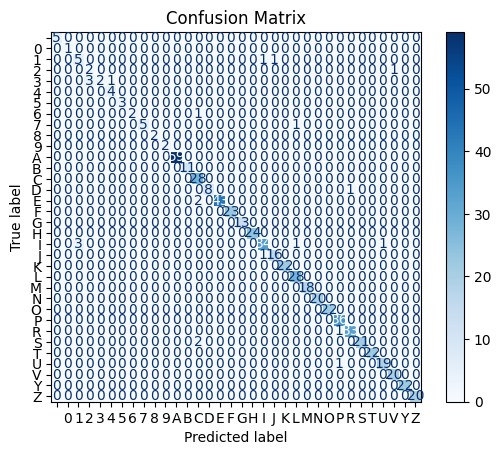

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Modeli değerlendirme moduna al
transfer_model.eval()

# Gerçek etiketler ve tahminler
true_labels = []
predicted_labels = []

# Test veri setinde gezin
with torch.no_grad():  # Eğitim sırasında gradient hesaplamasını devre dışı bırak
    for X, y in test_data_for_transfer_batches:
        # Tahminleri al
        predictions = transfer_model(X.to(device))
        _, preds = torch.max(predictions, 1)  # En yüksek olasılıklı sınıfı seç

        # Gerçek etiketleri ve tahminleri listeye ekle
        true_labels.extend(y.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Confusion matrix oluştur
cm = confusion_matrix(true_labels, predicted_labels)

# Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data_for_transfer.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [134]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [135]:
import gradio as gr

In [136]:
class_names=train_data.classes

In [137]:
def predict(img):
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
   # img=Image.open(img)
    # Transform the target image and add a batch dimension
    img = transfer_model_transformer(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    transfer_model.eval()
    transfer_model.to("cpu")
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(transfer_model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}


    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs

In [138]:
# Create title, description and article strings
title = "SIGN - BRIDGE"
description = "An artificial intelligence application that recognizes Hand gesture and translate to text"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=len(class_names), label="Predictions")], # what are the outputs?
                            # gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                   # examples=example_list,
                    title=title,
                    description=description)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d4e397a8b4646df742.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)




---


#GRADCAM TARAMASI



---




In [139]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 giriş boyutu
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [140]:
import torch
import cv2
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image

# Grad-CAM için gerekli olan hook fonksiyonları
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Forward hook - Aktivasyonları yakala
        self.target_layer.register_forward_hook(self.save_activations)

        # Backward hook - Gradients'leri yakala
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, image_tensor, class_idx):
        # Forward pass
        output = self.model(image_tensor)

        # Backward pass: Belirli bir sınıf için gradyanları hesapla
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0, class_idx] = 1
        output.backward(gradient=one_hot_output)

        # Gradients ve aktivasyonları al
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()

        # Global Ortalama Havuzlama (GAP) - Gradients'in ortalamasını al
        weights = np.mean(gradients, axis=(2, 3))  # (batch, channels)

        # Grad-CAM haritasını oluştur
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        # ReLU uygula (negatif değerleri sıfırla)
        cam = np.maximum(cam, 0)

        # Normalize et
        cam = cv2.resize(cam, (224, 224))  # ResNet giriş boyutuna ölçeklendir
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

In [141]:
target_layer = transfer_model.layer4[2].conv3  # ResNet50'de en derin katmanlardan biri
grad_cam = GradCAM(transfer_model, target_layer)

In [144]:
def apply_grad_cam(image_path, save_path="grad_cam_output.jpg"):
    # Görüntüyü yükle
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Görüntüyü PIL formatına çevir
    pil_image = Image.fromarray(img_rgb)

    # Modelin kabul edeceği formata çevir
    input_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Model ile tahmin yap
    # Move the model to the device as well
    transfer_model.to(device)  # Add this line

    with torch.no_grad():
        output = transfer_model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_index = torch.argmax(probabilities, dim=1).item()

    # Grad-CAM haritasını üret
    cam = grad_cam.generate_cam(input_tensor, predicted_index)

    # Isı haritası oluştur
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # Orijinal görüntüye ısı haritasını bindir
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Orijinal boyuta ölçekle
    overlayed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Görseli kaydet
    cv2.imwrite(save_path, overlayed_img)
    print(f"Grad-CAM çıktısı kaydedildi: {save_path}")

    # Görseli göster
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Grad-CAM Görselleştirme")
    plt.show()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Grad-CAM çıktısı kaydedildi: grad_cam_result.jpg


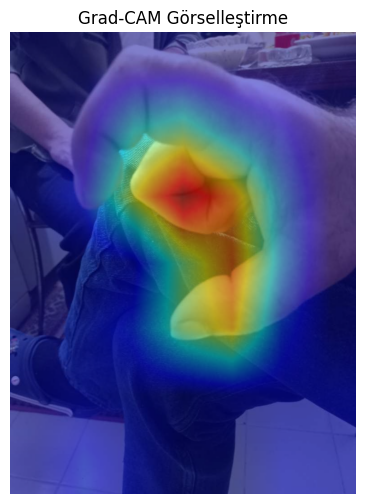

In [145]:
# Test için örnek bir görüntü kullan
test_image_path = '/content/sample_data/new_photo.png'
apply_grad_cam(test_image_path, save_path="grad_cam_result.jpg")